<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-deepar"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [ ]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

# Install pip packages

In [ ]:
!pip install mxnet
!pip install gluonts

# Select Task

In [3]:
task = 14

In [4]:
import pandas as pd

predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR164', 'VAR169', 'VAR175', 'VAR178', 'VAR228']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task+1}/train{task+1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

In [5]:
solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)
train_data

,ZONEID 1,ZONEID 2,ZONEID 3
TIMESTAMP,,,
2012-04-01 01:00:00,0.754103,0.647328,0.799000
2012-04-01 02:00:00,0.555000,0.621822,0.817500
2012-04-01 03:00:00,0.438397,0.472692,0.571500
2012-04-01 04:00:00,0.145449,0.098866,0.063775
2012-04-01 05:00:00,0.111987,0.104393,0.103700
...,...,...,...
2014-05-31 20:00:00,0.000000,0.000000,0.000000
2014-05-31 21:00:00,0.000064,0.000000,0.000025
2014-05-31 22:00:00,0.001090,0.000243,0.002200


In [6]:
# add total cloud cover * surface solar radiation predictor
predictors['VAR164*169'] = predictors['VAR164'] * predictors['VAR169']

In [7]:
predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178', 'VAR228', 'VAR164*169']]
                             .rename({'VAR169': f'SSRD {i}',
                                      'VAR175': f'STRD {i}',
                                      'VAR178': f'TSR {i}', 
                                      'VAR228': f'TP {i}',
                                      'VAR164*169': f'TCC*SSRD {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [8]:
for i in range(1, 4):
    predictor_data[f'SSRD {i}'] /= predictor_data[f'SSRD {i}'].max()
    predictor_data[f'STRD {i}'] /= predictor_data[f'STRD {i}'].max()
    predictor_data[f'TSR {i}'] /= predictor_data[f'TSR {i}'].max()
    predictor_data[f'TP {i}'] /= predictor_data[f'TP {i}'].max()
    predictor_data[f'TCC*SSRD {i}'] /= predictor_data[f'TCC*SSRD {i}'].max()
predictor_data

,SSRD 1,STRD 1,TSR 1,TP 1,TCC*SSRD 1,SSRD 2,STRD 2,TSR 2,TP 2,TCC*SSRD 2,SSRD 3,STRD 3,TSR 3,TP 3,TCC*SSRD 3
TIMESTAMP,,,,,,,,,,,,,,,
2012-04-01 01:00:00,0.075036,0.034681,0.076927,0.000000,0.018787,0.075329,0.034523,0.077026,0.000000,0.014867,0.075275,0.033892,0.076928,0.000000,0.018727
2012-04-01 02:00:00,0.155907,0.070565,0.159924,0.000000,0.072952,0.156009,0.070098,0.159798,0.000000,0.083382,0.154586,0.068502,0.158553,0.013823,0.090693
2012-04-01 03:00:00,0.230590,0.106171,0.240292,0.028372,0.182081,0.228093,0.105521,0.238421,0.024993,0.166247,0.222792,0.103328,0.233886,0.029863,0.153982
2012-04-01 04:00:00,0.287023,0.141938,0.304604,0.052930,0.283767,0.282115,0.141474,0.300619,0.034330,0.289635,0.277811,0.138698,0.296348,0.037236,0.273252
2012-04-01 05:00:00,0.324356,0.180378,0.352287,0.070487,0.313639,0.320843,0.179882,0.349239,0.041639,0.310906,0.319244,0.175985,0.346746,0.045280,0.315048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-31 20:00:00,0.177391,0.702846,0.220841,0.045888,0.181576,0.177643,0.709459,0.219739,0.033087,0.183597,0.182488,0.712321,0.221487,0.036180,0.190634
2014-05-31 21:00:00,0.177391,0.738251,0.220841,0.076096,0.181576,0.177643,0.743803,0.219739,0.038304,0.183597,0.182488,0.745575,0.221487,0.041633,0.190634
2014-05-31 22:00:00,0.178456,0.774921,0.223835,0.093753,0.182667,0.178895,0.780254,0.222831,0.050370,0.184891,0.183974,0.781593,0.224705,0.058317,0.192186


In [9]:
# define the parameters of the dataset
gefcom14_metadata = {'num_series': 3,
                     'num_steps': len(predictor_data),
                     'prediction_length': len(benchmark) // 3, # three different timezones
                     'freq': '1H',
                     'start': [pd.Timestamp(predictor_data.index[0], freq='1H') for _ in range(3)]
                     }

In [10]:
targets = [train_data[:-gefcom14_metadata['prediction_length']][f'ZONEID {i}'].values for i in [1,2,3]]
starts = gefcom14_metadata['start']
features = [predictor_data[:-gefcom14_metadata['prediction_length']][[f'SSRD {i}', f'STRD {i}', f'TSR {i}', f'TP {i}', f'TCC*SSRD {i}']].values.T for i in [1,2,3]]

In [11]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: fdr,
    FieldName.FEAT_STATIC_CAT: [fsc]
  } for (target, start, fdr, fsc) in zip(targets, starts, features, [1,2,3])], 
  freq=gefcom14_metadata['freq'])

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [12]:
targets = [train_data[f'ZONEID {i}'].values for i in [1,2,3]]
starts = gefcom14_metadata['start']
features = [predictor_data[[f'SSRD {i}', f'STRD {i}', f'TSR {i}', f'TP {i}', f'TCC*SSRD {i}']].values.T for i in [1,2,3]]

In [13]:
test_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: fdr,
    FieldName.FEAT_STATIC_CAT: [fsc]
  } for (target, start, fdr, fsc) in zip(targets, starts, features, [1,2,3])], 
  freq=gefcom14_metadata['freq'])

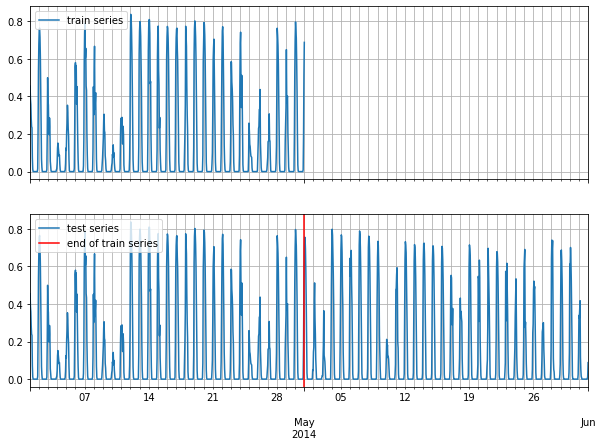

In [14]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

train_series = to_pandas(train_entry)
test_series = to_pandas(test_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series[-24*30:].plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series[-24*30-gefcom14_metadata['prediction_length']:].plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [15]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import PiecewiseLinearOutput

estimator = DeepAREstimator(freq=gefcom14_metadata['freq'],
                            prediction_length=gefcom14_metadata['prediction_length'],
                            distr_output=PiecewiseLinearOutput(num_pieces=3), # SQF-RNN
                            use_feat_dynamic_real=True,
                            trainer=Trainer(epochs=7))

ensemble_count = 7
predictors = []

for _ in range(ensemble_count):
    predictor = estimator.train(train_ds)
    predictors.append(predictor)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [02:03<00:00,  2.47s/it, epoch=7/7, avg_epoch_loss=0.0243]


In [16]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm import tqdm

forecast_ensemble = []
tss_ensemble = []

for predictor in tqdm(predictors):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=500,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    forecast_ensemble.append(forecasts)
    tss_ensemble.append(tss)

100%|██████████| 7/7 [06:15<00:00, 53.64s/it]


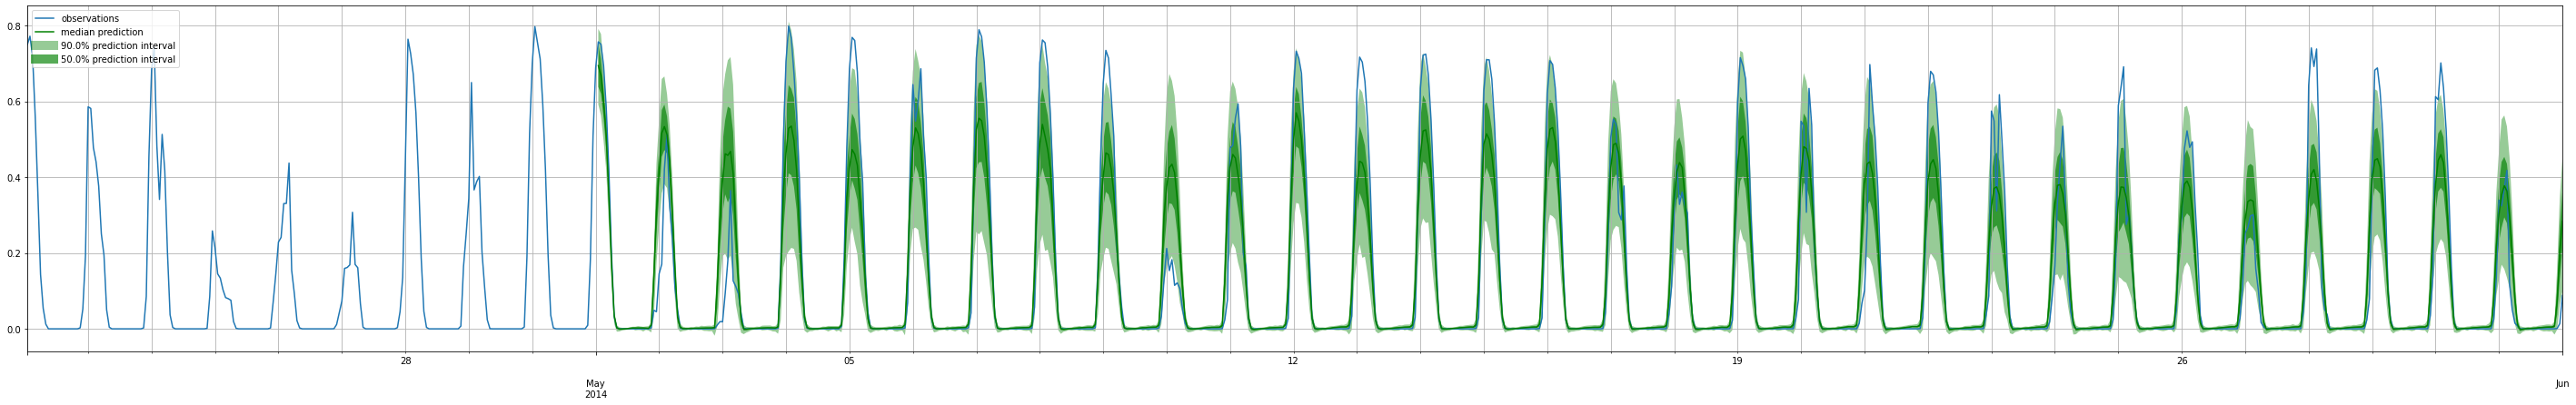

In [17]:
def plot_prob_forecasts(ts_entry, forecast_entry, output_file=None):
    plot_length = 24 * 40
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(50, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()

plot_prob_forecasts(tss[0], forecasts[0])

In [18]:
import numpy as np

prediction_ensemble = []

for forecasts in forecast_ensemble:
    zone_predictions = []
    for i, forecast in enumerate(forecasts):
        prediction = pd.concat([np.maximum(forecast.quantile_ts(p/100), 0)
                                for p in range(1, 100)], axis=1)\
            .rename(columns={p: str((p+1)/100) for p in range(99)})
        prediction.insert(0, 'ZONEID', i+1)
        prediction.index.name = 'TIMESTAMP'
        zone_predictions.append(prediction)

    predictions = pd.concat(zone_predictions)
    prediction_ensemble.append(predictions)

In [19]:
!mkdir -p results

In [20]:
averaged_predictions = pd.DataFrame()

for p in range(1, 100):
    quantile_columns = [prediction[str(p/100)] for prediction in prediction_ensemble]
    averaged_predictions.insert(p-1, str(p/100), np.mean(quantile_columns, axis=0))

averaged_predictions.insert(0, 'ZONEID', np.array(prediction_ensemble[0]['ZONEID']))
averaged_predictions.insert(0, 'TIMESTAMP', prediction_ensemble[0].index)
averaged_predictions = averaged_predictions.set_index('TIMESTAMP')
    
averaged_predictions.to_csv(f'results/prediction_sqf_rnn_task{task}.csv')

averaged_predictions

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-05-01 01:00:00,1,0.557651,0.561822,0.565797,0.569278,0.573471,0.577370,0.581233,0.585120,0.589738,0.592673,0.597516,0.599654,0.603736,0.607495,0.612212,0.615343,0.619636,0.624624,0.629379,0.632511,0.634778,0.636997,0.640244,0.642404,0.646263,0.650010,0.652628,0.656078,0.660300,0.663015,0.665850,0.667966,0.669656,0.671505,0.673962,0.675261,0.676973,0.677907,0.679353,...,0.711365,0.712771,0.714404,0.715627,0.717496,0.718889,0.720517,0.721845,0.723100,0.724252,0.725716,0.727248,0.729013,0.730203,0.731610,0.733223,0.735101,0.736312,0.737650,0.739281,0.740627,0.742139,0.743730,0.746232,0.748967,0.752018,0.754306,0.755991,0.758653,0.761201,0.763700,0.766650,0.770405,0.772183,0.775105,0.777731,0.780134,0.782056,0.785618,0.789257
2014-05-01 02:00:00,1,0.486820,0.505362,0.512146,0.516997,0.521172,0.527464,0.532310,0.535790,0.540558,0.543690,0.548928,0.553246,0.556728,0.559971,0.563106,0.566732,0.569741,0.572701,0.575282,0.577075,0.579976,0.582438,0.586226,0.588070,0.590908,0.593253,0.596169,0.597521,0.599425,0.601612,0.603257,0.604873,0.606960,0.609099,0.610970,0.613333,0.615070,0.617232,0.619465,...,0.655468,0.657340,0.658770,0.660519,0.662350,0.664256,0.665704,0.667465,0.669205,0.670954,0.672552,0.674109,0.676531,0.678221,0.679635,0.681307,0.682885,0.684906,0.686196,0.687394,0.689119,0.691642,0.693458,0.696083,0.698176,0.701157,0.704855,0.708717,0.711607,0.714937,0.718566,0.722381,0.725677,0.729068,0.732671,0.738768,0.744140,0.747882,0.753370,0.762944
2014-05-01 03:00:00,1,0.437189,0.451396,0.464277,0.472509,0.479665,0.484711,0.489873,0.494143,0.497510,0.501949,0.505210,0.508050,0.511100,0.514746,0.517268,0.521064,0.524336,0.527674,0.530846,0.534132,0.536010,0.538304,0.541579,0.543649,0.545897,0.548379,0.550395,0.552528,0.554397,0.556116,0.558418,0.560576,0.562091,0.564164,0.566185,0.568189,0.570623,0.572847,0.575322,...,0.613038,0.614574,0.615969,0.617105,0.618511,0.619873,0.621744,0.623352,0.625090,0.627118,0.628814,0.630643,0.632440,0.633928,0.635674,0.637738,0.639332,0.641011,0.643620,0.646371,0.648531,0.650889,0.652655,0.654665,0.656984,0.659286,0.661671,0.664126,0.666749,0.671049,0.674103,0.678048,0.682543,0.685653,0.688226,0.692843,0.696447,0.703740,0.709942,0.723835
2014-05-01 04:00:00,1,0.361780,0.379577,0.390166,0.396542,0.402205,0.408297,0.413878,0.419109,0.422468,0.425728,0.429134,0.432909,0.436366,0.438867,0.441086,0.443624,0.445839,0.448602,0.451888,0.455169,0.458002,0.459952,0.461584,0.463530,0.465500,0.467262,0.469585,0.471441,0.473192,0.475198,0.476937,0.478865,0.480464,0.482159,0.483569,0.484898,0.487134,0.489575,0.491602,...,0.526301,0.528576,0.530129,0.531505,0.533052,0.535530,0.537384,0.538888,0.540655,0.543205,0.544884,0.547481,0.548970,0.550510,0.552609,0.554207,0.556316,0.558026,0.560469,0.562390,0.565285,0.567033,0.569062,0.572420,0.574753,0.576872,0.579533,0.581993,0.584541,0.586945,0.589766,0.592592,0.596683,0.601634,0.605186,0.610359,0.615746,0.622098,0.630475,0.641383
2014-05-01 05:00:00,1,0.234589,0.246370,0.254549,0.262830,0.268171,0.272627,0.276113,0.280205,0.283525,0.286283,0.290324,0.293903,0.296373,0.298133,0.300492,0.302396,0.304850,0.306781,0.309115,0.311663,0.313531,0.314813,0.317178,0.319440,0.320857,0.322387,0.324317,0.326087,0.327589,0.329426,0.331030,0.332541,0.334488,0.336134,0.337898,0.339137,0.340470,0.341458,0.343050,...,0.374005,0.375451,0.376830,0.378531,0.380122,0.381715,0.383156,0.384851,0.386232,0.387591,0.389169,0.390478,0.392065,0.393528,0.395044,0.396586,0.398173,0.400229,0.401600,0.403630,0.40

## Plotting the quantile prediction for the first entries

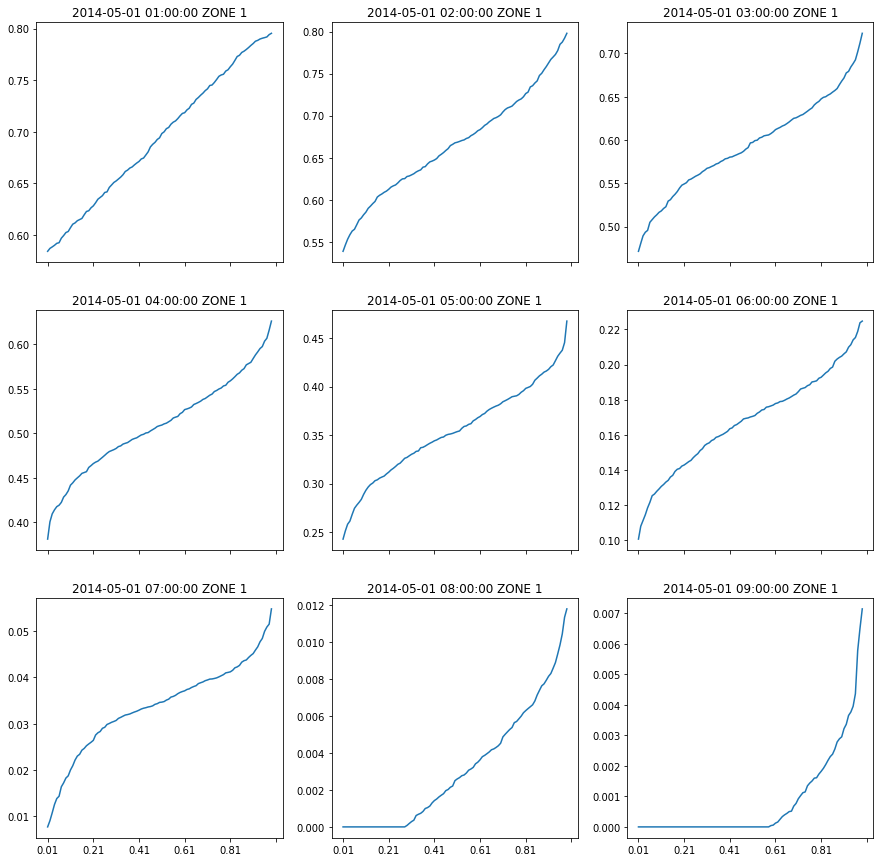

In [21]:
fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    predictions.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3], 
                                      title=str(predictions.index[i]) + ' ZONE ' 
                                      + str(int(predictions.iloc[i]['ZONEID'])))

# Evaluate Loss

The loss function is the pinnball loss: 
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [22]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction, 
                    (1 - percentiles / 100) * (prediction - actual), 
                    percentiles / 100 * (actual - prediction))
    return loss

loss1 = np.mean(pinnball_loss(tss[0].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 1].drop('ZONEID', axis=1)))
loss2 = np.mean(pinnball_loss(tss[1].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 2].drop('ZONEID', axis=1)))
loss3 = np.mean(pinnball_loss(tss[2].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 3].drop('ZONEID', axis=1)))

print(f"Loss of task {task}: {round((loss1 + loss2 + loss3) / 3, 5)}")

Loss of task 14: 0.01779


In [23]:
loss1 = np.mean(pinnball_loss(tss[0].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 1].drop('ZONEID', axis=1)))
loss2 = np.mean(pinnball_loss(tss[1].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 2].drop('ZONEID', axis=1)))
loss3 = np.mean(pinnball_loss(tss[2].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 3].drop('ZONEID', axis=1)))

print(f"Benchmark loss of task {task}: {round((loss1 + loss2 + loss3) / 3, 5)}")

Benchmark loss of task 14: 0.03198
